# Boston COVID19
> Modeling the potential spread of COVID19 in the greater boston area.

- toc: true 
- badges: true
- comments: true
- categories: [jupyter]
- image: images/chart-preview.png

## Context

Recently Boston became a COVID19 hotspot due to an outbreak occurring at biogen. This happens to be a company located approximately 2 blocks from my apartment. We share restaurants, transit hubs and more. Since this hits a little close to home, I wanted to take a look at the suspected growth rate for the total possible number of infected people in the boston area.

To do this, we will use the SIR model and we can also create a forecasting model using prophet to track the predicted vs. actual. 

In [1]:
#collapse-hide
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from sklearn.cluster import KMeans
import datetime
from datetime import date, timedelta
from fbprophet import Prophet
from datetime import datetime
import requests
from io import StringIO

In [2]:
bytes_csv = str(requests.get("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv", allow_redirects=True).content,'utf-8')
data = StringIO(bytes_csv) 
df=pd.read_csv(data, parse_dates=True)
df.dropna(inplace=True)
df = df[df['Province/State'].str.contains('Massachusetts')].iloc[:,4:].copy().T
df.columns = ['Confirmed']

In [3]:
df['Date'] = df.index
df['Date'] = df['Date'].apply(lambda x: datetime.strptime(x, '%m/%d/%y'))
df.set_index('Date',inplace=True)

In [4]:
df.tail()

,Confirmed
Date,
2020-03-08,0
2020-03-09,0
2020-03-10,92
2020-03-11,95
2020-03-12,108


## Modeling the growth of a region

Since we don't have a lot of data for Boston, we can use SIR as a model to estimate the growth in the area.

We will make some assumptions around the population because it is most likely feasible that only certain mobile areas of the greater boston population would be affected. In addition, since schools have closed and work from home is already mandated, we can probably further reduce our contact rate to the lower of the range shown for the coronavirus.

In [5]:
population = 4875390
saturation_coeff = .6 # estimated possible population saturation
density_coeff=.5 # 1/2 of wuhan density

# Using the SIR model to determine growth

* recovery rate, gamma = 1/5 - 1 person takes on average 5 days to pass through the contagious stage [1](https://www.cdc.gov/coronavirus/2019-ncov/hcp/clinical-guidance-management-patients.html)
* contact rate, beta = .475 - This is difficult because it varies over time [2](https://www.sciencedirect.com/science/article/pii/S246804272030004X). This complicates things, since the early contact rate could be up to 10, but will decrease as restrictions are placed on the population, people self-isolate etc. For this estimation we will assume a contact rate of 0.5 after fitting the SIR to the Italy EDA I previously completed [here](https://github.com/awmatheson/COVID-19/blob/master/Italy_EDA.ipynb). 
* Approximately 15% of cases require hospitalization based on the China outbreak and 5% require ICU treatment [3](https://www.statnews.com/2020/03/10/simple-math-alarming-answers-covid-19/)
* Massachusetts has 15,193 beds available and approximately operate at 50% capacity - leaving ~7597 beds. [4](https://www.ahd.com/states/hospital_MA.html)
* population adjusted is based on the estimation that sparser populated areas do not have as high of transmission rates and can be fairly isolated from the rest of the population.


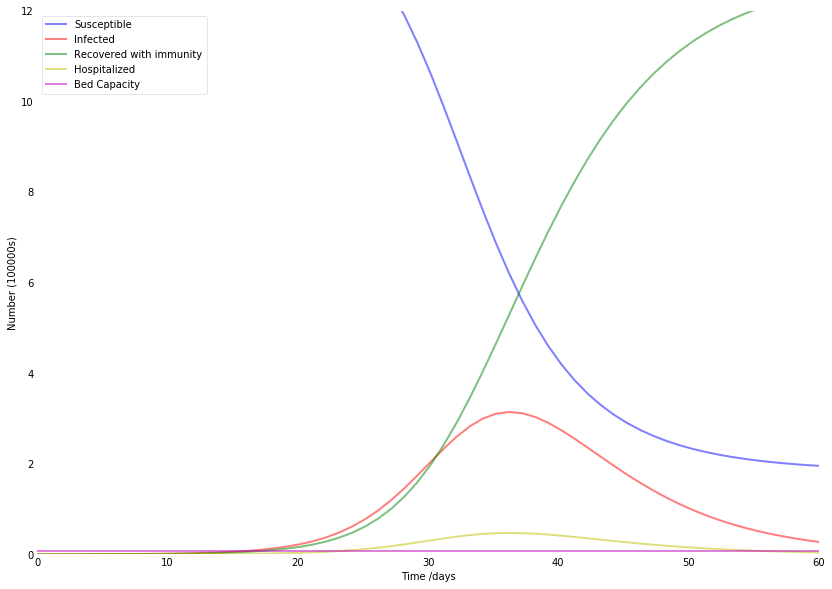

targeted population in this model: 1462617.0
critical infected population at inflection point: 314103.19593972364
critical hospitalized population: 47115.47939095854


In [6]:
#collapse-show
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Total population adjusted for assumptions listed above
N = population * saturation_coeff * density_coeff
hosp_rate= 0.15
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 91, 1
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.475, 1/5 
# A grid of time points (in days)
t = np.linspace(0, 160, 160)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T
H = I*hosp_rate
beds = np.array([7597 for i in range(len(H))])

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w', figsize= (14,10))
ax = fig.add_subplot(111, axisbelow=True)

ax.plot(t, S/100000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/100000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/100000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.plot(t, H/100000, 'y', alpha=0.5, lw=2, label='Hospitalized')
ax.plot(t, beds/100000, 'm', alpha=0.5, lw=2, label='Bed Capacity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (100000s)')
ax.set_ylim(0,12)
ax.set_xlim(0,60)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()
print("targeted population in this model: {}".format(N))
print("critical infected population at inflection point: {}".format(I.max()))
print("critical hospitalized population: {}".format(I.max()*hosp_rate))

We can observe that with this SIR model we could see approximately 314,000 infected people and 47,115 people requiring hospitalization. We will run out of bed capacity eventually, which is the situation that happened in Italy. Without the ability to build massize isolated treatment centers like china did, there are not many options for creating hospitals that will have the necessary treatment capabilities for the virus.

Lets zoom in on the capacity below.

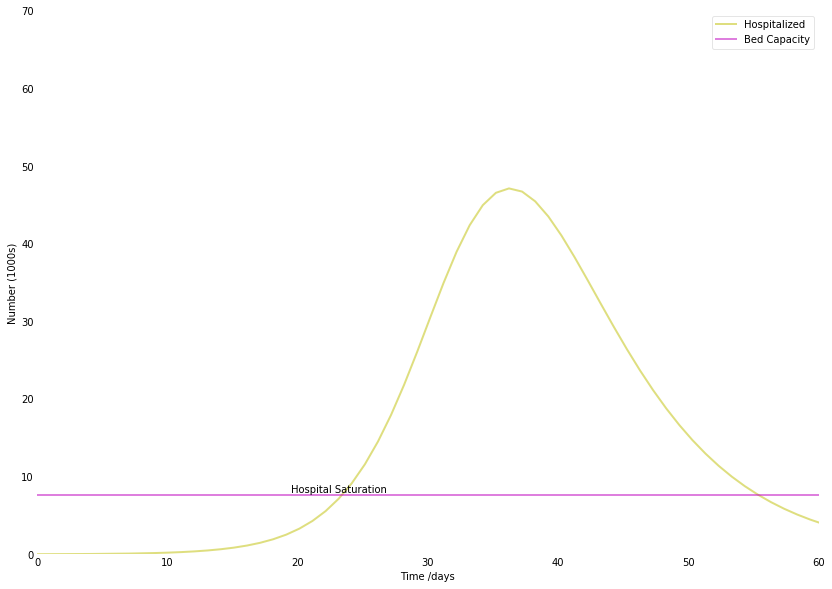

In [7]:
# Zooming in
fig = plt.figure(facecolor='w', figsize= (14,10))
ax = fig.add_subplot(111, axisbelow=True)

ax.plot(t, H/1000, 'y', alpha=0.5, lw=2, label='Hospitalized')
ax.plot(t, beds/1000, 'm', alpha=0.5, lw=2, label='Bed Capacity')
ax.text(t[23], 8, "Hospital Saturation", ha='center')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(0,70)
ax.set_xlim(0,60)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

## Conclusion

The visualization above shows that approximately 23-25 days after the initial group of patients tested positive, we could reach hospital bed saturation for Massachusetts based off of the greater boston population (adjusted) being infected by the virus. 

This could cause a change in the contact rate that we assumed for our model and increase the infected patients. Based on this analysis, we could see deaths into the 10s of thousands in the next few months depending on the demographics of the population infected. 

### References

* https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/
* https://www.sciencedirect.com/science/article/pii/S246804272030004X
* https://www.bphc.org/healthdata/other-reports/Documents/Healthcare%20Access%20Report%20FINAL.pdf
* https://www.cdc.gov/coronavirus/2019-ncov/hcp/clinical-guidance-management-patients.html
* https://www.ahd.com/states/hospital_MA.html